# Project 1

## One-dimensional diffusion model for CO2 absorption in the ocean

**TMA4320 Introduksjon til vitenskapelige beregninger**

**Introduction:** 

In this project we will look at a one-dimensional model of the ocean, and how $CO_2$ is absorbed from the atmosphere into the ocean, and diffuses to deeper depths.

Importing libraries:

In [1]:
# Matplotlib for plotting
%matplotlib inline
from matplotlib import pyplot as plt

# Numpy for almost everything
import numpy as np

# Some scipy functions for sparse diagonal matrices
from scipy.sparse import diags

# scipy function to numerically calculate integral
from scipy.integrate import simps

# just-in-time (jit) compiler from numba, to speed up the loop in the TDMA solver
# If this line gives you trouble, then you can either
# install numba (recommended) or you can comment it out
from numba import jit

Some constants:

In [2]:
K0 = 1E-3
Ka = 2E-2
Kb = 5E-2
za = 7
zb = 10
kw = 6.97E-5
T = 180*3600*24 # 180 days
N = 1800
Nz = 500
L = 100
H = 5060

Defining functions and some arrays:

$K$ and $K'$ here are for problem 1.

In [3]:
t = np.linspace(0,T,N+1)
K = np.zeros(Nz+1)
K_mark = np.zeros(Nz+1)
dt = T/(N)
dz = L/(Nz)
dz_squared = dz**2
z = np.linspace(0,L,Nz+1)

def Kfunc(z,Nz):
    for i in range(Nz+1):
        K[i] = K0 + Ka*(z[i]/za)*np.exp(-z[i]/za) + Kb*((L-z[i])/zb)*np.exp(-(L-z[i])/zb)
    return K

def K_markfunc(z,Nz):
    K = Kfunc(z,Nz)
    for i in range(1,Nz):
        K_mark[i] = K[i+1] - K[i-1]
    return K_mark

def Ceq(Pco):     # equilibrium concentration
    return H*Pco

def j_mt(C0,Ceq):
    return -kw*(C0-Ceq)

def alphafunc(dt):
    return dt/(2*dz_squared)

def gammafunc(alpha,K):
    return 2*alpha*kw*dz*(1-((K[1]-K[0])/(2*K[0])))

Here we make the matrices $L$, $R$ and $S$. $L$ and $R$ are tridiagonal matrices. To make these we made an upper diagonal, a lower diagonal and a diagonal, and then we put these together to make the tridiagonal matrix. To make $S$, we only made an array with zeros, and changed the first value. This $S$ is made with the assumption that it does not change over time.

In [4]:
K = Kfunc(z,Nz)
K_mark = K_markfunc(z,Nz)
alpha = alphafunc(dt)
gamma = gammafunc(alpha,K)

def matrix(z,Pco,Nz):
    
    L_mid = np.zeros(Nz+1)
    L_upper = np.zeros(Nz)
    L_lower = np.zeros(Nz)
    R_mid = np.zeros(Nz+1)
    R_upper = np.zeros(Nz)
    R_lower = np.zeros(Nz)

    for i in range(Nz+1):
        L_mid[i] = 1 + 2 * alpha * K[i]
        R_mid[i] = 1 - 2 * alpha * K[i]
    for i in range(Nz):
        L_upper[i] = -alpha/4 * K_mark[i] - alpha * K[i]
        L_lower[i] = alpha/4 * K_mark[i+1] - alpha * K[i+1]
        R_upper[i] = alpha/4 * K_mark[i] + alpha * K[i]
        R_lower[i] = -alpha/4 * K_mark[i+1] + alpha * K[i+1]

    L_mid[0] += gamma
    R_mid[0] -= gamma
    L_upper[0] = -2*alpha * K[0]
    R_upper[0] = 2*alpha * K[0]
    L_lower[-1] = -2*alpha * K[Nz]
    R_lower[-1] = 2*alpha * K[Nz]
    
    L_matrix = diags([L_upper, L_mid, L_lower], offsets = [1, 0, -1])
    R = diags([R_upper, R_mid, R_lower], offsets = [1, 0, -1])
    
    S = np.zeros(Nz+1)
    S[0] = 2*gamma*Ceq(Pco)
    
    return L_matrix,R,S

Testing if the matrices can be correct. *True* means that the matrices may be correct: 

In [5]:
L_matrix,R,S = matrix(z,415E-6,Nz)

print(np.allclose(L_matrix.todense(), 2*np.identity(Nz+1)-R.todense()))

True


Matrix-solver:

In [6]:
# just-in-time (jit) compiler from numba, to speed up the loop in the TDMA solver
# If this line gives you trouble, then you can either
# install numba (recommended) or you can comment it out
@jit(nopython = True)
def tdma_solver(a, b, c, d):
    # Solves Ax = d,
    # where layout of matrix A is
    # b1 c1 ......... 0
    # a2 b2 c2 ........
    # .. a3 b3 c3 .....
    # .................
    # .............. cN-1
    # 0 ..........aN bN
    # Note index offset of a
    N = len(d)
    c_ = np.zeros(N-1)
    d_ = np.zeros(N)
    x  = np.zeros(N)
    c_[0] = c[0]/b[0]
    d_[0] = d[0]/b[0]
    for i in range(1, N-1):
        c_[i] = c[i]/(b[i] - a[i-1]*c_[i-1])
    for i in range(1, N):
        d_[i] = (d[i] - a[i-1]*d_[i-1])/(b[i] - a[i-1]*c_[i-1])
    x[-1] = d_[-1]
    for i in range(N-2, -1, -1):
        x[i] = d_[i] - c_[i]*x[i+1]
    return x

def tdma(A, b):
    # Solves Ax = b to find x
    # This is a wrapper function, which unpacks
    # A from a sparse diagonal matrix structure into separate diagonals,
    # and pass them to the numba-compiled solver defined above.
    # Note, this method needs A to be diagonally dominant
    # (which it will be, for this problem)
    x = tdma_solver(A.diagonal(-1), A.diagonal(0), A.diagonal(1), b)
    return x

Function *solver* will solve equation 2:

In [7]:
def solver(L_matrix,R,S,C0,runs,problem2=False):
    if not problem2:
        C1 = C0
        for i in range(runs):   
            V = R.dot(C0) + S
            C1 = tdma(L_matrix,V)
            C0 = C1
        return C1
    else:
        C_simulation =[C0]
        for i in range(runs):
            V = R.dot(C0) + (S[i]+S[i+1])/2
            C1 = tdma(L_matrix,V)
            C0 = C1
            C_simulation.append(C1)
        return C1, C_simulation

### Problem 1

In problem 1 we will look at a shallow area, like the Norwegian Continental shelf. What we are interested in, is how the ocean reacts to changes in the $CO_2$-levels in the atmosphere, and if the concentration of Dissolved Inorganic Carbon (DIC) in the water lags behind the changes in the atmosphere. 

By assuming that the initial concentration of DIC in the ocean is zero, we induce a process where the $CO_2$ is absorbed from the atmosphere into the ocean and then disperses to reach the equilibrium concentration. This is, of course, a simplification since the concentration of DIC in the ocean is not zero. However, it gives us an oppurtunity to study how the ocean will react to sudden changes in the concentration of $CO_2$ in the atmosphere, and more specifically if the ocean floor lags behind. 

For problem 1 we express the diffusivity as 

\begin{align}
K(z)=K_0 + K_a \frac{z}{z_a} e^{(-\frac{z}{z_a})} + K_b \frac{L-z}{z_b} e^{(-\frac{L-z}{z_b})}. \label{K1}\tag{1}
\end{align}

Equation \ref{K1} represent conditions where the water near the surface is influenced by wind, and the water near the bottom is influenced by friction of the current against the sea floor.

**Problem 1 Task 1:** The intention is to illustrate the flow of $CO_2$ from the atmosphere into the ocean, with an initial concentration of DIC equaled to zero. The concentration of $CO_2$ in the atmosphere is equal to $415$ ppm, and the time interval is $180$ days. To achieve this, we solved the equation 

\begin{align}
LC^{i+1} = V = RC^{i} + \frac{1}{2}(S^{i}+S^{i+1}), \label{eq1}\tag{2}
\end{align}

derived in appendix $2$, for concentration $C$, by using the function *solver*.

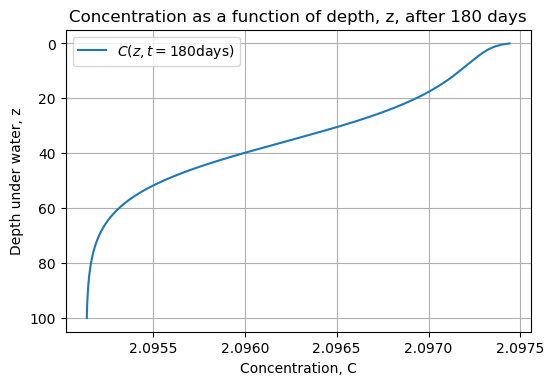

In [8]:
def task1(Nz,runs):
    kw = 6.97E-5
    globals()["gamma"] = gammafunc(alpha,K)
    Pco = 415E-6
    C0 = np.zeros(Nz+1)
    L_matrix,R,S = matrix(z,Pco,Nz)
    C1 = solver(L_matrix,R,S,C0,runs)
    return C1
C_z = task1(Nz,N)

plt.figure(dpi=100)
plt.title('Concentration as a function of depth, z, after 180 days')
plt.xlabel('Concentration, C')
plt.ylabel('Depth under water, z')
plt.plot(C_z,z,label=r'$C(z,t=180$days)')
plt.gca().invert_yaxis()
plt.legend()
plt.grid()
plt.show()

Illustrated by the figure *Concentration as a function of depth, z, after 180 days*, we can see that the concentration of DIC in the ocean decreases by depth at this point. But notice that the axis show us that the difference between maximum and minimum is small. The highest concentration of DIC is at the sea level, while the lowest concentration is at the bottom of the ocean ($100$ meters below sea level). 

This makes sense because the ocean will absorb $CO_2$ from the atmosphere, and it will be absorbed at the surface first. From there the DIC will be diffused to the rest of the ocean, so it makes sense that the concentration is lowest at the bottom since it will take more time to spread all the way down.

**Problem 1 Task 2:** In this task the variable we wanted to plot the concentration for changed from depth to time. Then it became necessary to establish two constant depths where the concentration of DIC was on its highest and lowest, and then solve equation 2, but now for increasing time. We can then observe, by the figure *Concentration as a function of time*, that the concentration approaches the equilibrium concentration as the time increases.  

With the initial concentration equal to zero, the ocean will absorb DIC from the atmosphere. At the beginning, the changes will be large, but the changes will gradually decrease until the concentration reaches equilibrium. Then there will no longer be a flow of DIC from the atmosphere to the ocean, and therefore the concentration in the ocean will approach equilibrium and not increase above the equilibrium value. 

To solve this task we used our function *solver* to give us the concentration at different timesteps, and then we plotted the maximum and minimum values for each timestep.

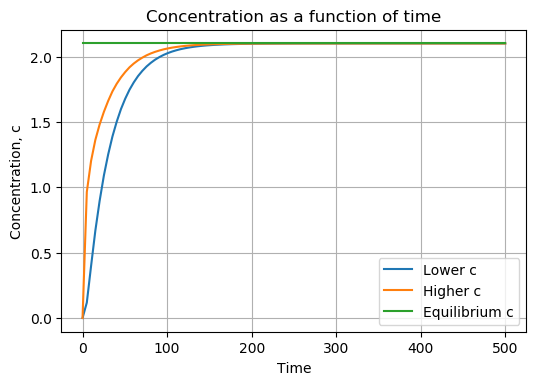

In [9]:
newtime = np.linspace(0,4999,100)
Cl = np.zeros(100)
Ch = np.zeros(100)
eq = np.zeros(100)
for i in range(100):
    C = task1(Nz,int(newtime[i]))
    Cl[i] = min(C)                 # The maximum concentration
    Ch[i] = max(C)                 # The minimum concentration
    eq[i] = Ceq(415E-6)            # Equilibrium concentration
    
plt.figure(dpi=100)
plt.title("Concentration as a function of time")
plt.plot(newtime/10,Cl,label="Lower c")
plt.plot(newtime/10,Ch,label="Higher c")
plt.plot(newtime/10,eq,label="Equilibrium c")
plt.xlabel("Time")
plt.ylabel("Concentration, c")
plt.legend()
plt.grid()
plt.show()

The plot shows us that the concentration will reach equilibrium after approximately $180$ days, which is the length we used in the previous task. Thus it makes sense that the difference in concentration from surface to sea floor in the previous task was so small.

**Problem 1 Task 3:** Here we solved the same equation as a function of depth, like in task 1, but this time we solved the equation for several constant times. We chose five different times: $0.1$ day, $1$ day, $10$ days, $100$ days and $180$ days. The figure then depicts how the concentration in the ocean has changed for the different time values. 

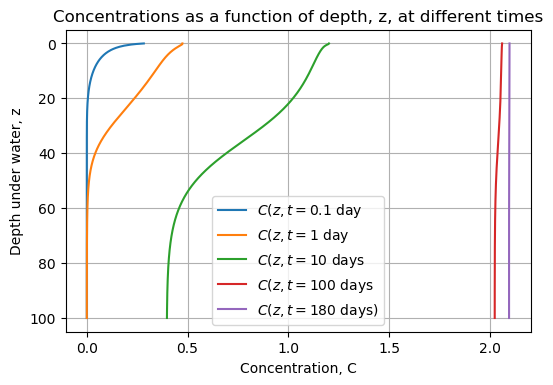

In [10]:
plt.figure(dpi=100)
plt.title('Concentrations as a function of depth, z, at different times')
plt.xlabel('Concentration, C')
plt.ylabel('Depth under water, z')
plt.plot(task1(Nz,1),z,label=r'$C(z,t=0.1$ day')
plt.plot(task1(Nz,10),z,label=r'$C(z,t=1$ day')
plt.plot(task1(Nz,100),z,label=r'$C(z,t=10$ days')
plt.plot(task1(Nz,1000),z,label=r'$C(z,t=100$ days')
plt.plot(task1(Nz,N),z,label=r'$C(z,t=180$ days)')
plt.gca().invert_yaxis()
plt.legend()
plt.grid()
plt.show()

Our figure *Concentrations as a function of depth, z, at different times* illustrates that the concentration has the biggest change after the shortest amount of time. 

Over a longer time period, the concentration's rate of increase will decrease. This can be explained by studying the equilibrium between the concentration of DIC in the ocean and the atmosphere. The initial concentration of DIC in the ocean is assumed to be zero in this experiment, and therefore the ocean absorbs DIC from the atmosphere to achieve an equilibrium between the two systems. As the time passes by, the concentration in the ocean will increase, closer to an equilibrium. As we can see from *Concentration as a function of time*, the concentration will in the start move fast towards equilibrium, before it slows down when closer to equilibrium. 

Another interesting observation is that at the start, all of the DIC is on the top of the water column. But with time the concentration is evenly spread across the water column.

From this plot we can see that the concentration is approximately at equilibrium after $180$ days, which fits nicely with task 2.

**Problem 1 Task 4:**
From the figure *Concentrations as a function of depth, z, at different times* we can see that the change of concentration is at its most at the beginning. Unlike the rapid change at the surface, the change of concentration at the bottom of the ocean will lag behind. This is because the DIC needs time to diffuse, and after a short period of time all of the new DIC is still at the top. So for rapid and large changes, the change on the bottom is not "in sync" with the changes in the atmosphere. 

After a while we will get close to an equilibrium between the ocean and atmosphere, where the concentration is the same at the bottom and at the surface of the ocean. Here we can see that a smaller change of the concentration in the atmosphere will not affect the equilibrium enough to create significant differences in the changes at the bottom and at the surface of the ocean.

So with the current changes in the atmosphere we can say that the ocean at $100$m depth is "in sync" with the changes in the atmosphere.

### Problem 2

The intention of problem 2 is to estimate what an amount of $CO_2$ is absorbed by the ocean on an annual basis. Similarly to problem 1, we will consider the transportation of $CO_2$ from the atmosphere to the ocean as a mass transfer, where, at the surface, the $CO_2$ is then transformed into DIC. The DIC is later mixed down to greater depths by diffusion. In the following tasks, we will assume a water depth of $4000$m. 

We also assumed that the ocean is in equilibrium with the atmosphere at the start. Therefore, it is also interesting to study the absorption of $CO_2$ in the ocean as the concentration in the atmosphere continue to increase. 

When we assumed an initial concentration equal to zero in the first problem, we could witness that the change of concentration of DIC in the beginning was much larger than the change after some time. Now we can expect a smaller increase in concentration overall, considering the equilibrium between the ocean and the atmosphere, and a small change in the atmospheric concentration.

**Problem 2 Task 1:**
In this task, we assume that the initial concentration of DIC in the ocean in the year $2020$ is constant with depth, and in equilibrium with the concentration of $CO_2$ in the atmosphere. The initial concentration in the atmosphere is set to $415$ppm and the concentration of $CO_2$ increases by $2.3$ppm each year. From equation 2 and 

\begin{align}
K(z) = K_1 \frac{K_0 - K_1}{1 + e^{-a(z-z_0)}} \label{K2}\tag{3}
\end{align}

we run a simulation for $10$ years, from the year $2020$ to $2030$. To do this we again used the equation *solver*, but now a bit changed as a result of a changing concentration of $CO_2$, which gives us a $S$ in equation 2 that changes over time.

Here we assume that the concentration will increase by $2.3$ppm each year. In reality, this amount will probably increase, but for simplicity we assume it to be constant. The real future increase will probably not be too different from the current, so it is assumed to be a reasonable simplification.

**Problem 2 Task 2:**
We calculate, then plot the simulation for the timeperiods $2.5$, $5$ and $10$ years, in addition to the start value.

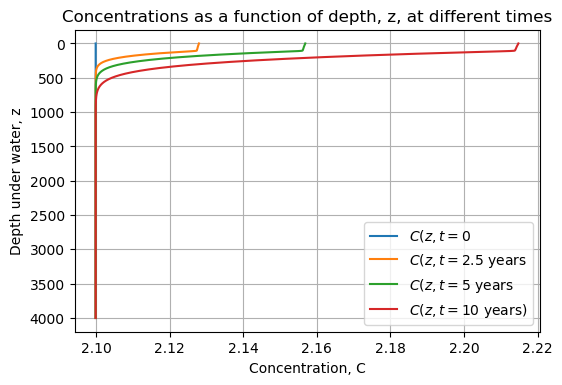

In [11]:
L = 4000                 # New depth
K0 = 1e-4
K1 = 1e-2
a = 0.5
z0 = 100
T = 10*365*24*3600       # New time, 10 years 
N = 10*10*365
Nz = 4000

t = np.linspace(0,T,N+1)
K = np.zeros(Nz+1)
K_mark = np.zeros(Nz+1)
dt = T/(N)
dz = L/(Nz)
dz_squared = dz**2
z = np.linspace(0,L,Nz+1)

def Kfunc2(z,Nz):
    for i in range(Nz+1):
        K[i] = K1 + (K0 - K1)/(1+np.exp(-a*(z[i]-z0)))
    return K

def K_markfunc2(z,Nz):
    K = Kfunc2(z,Nz)
    for i in range(1,Nz):
        K_mark[i] = K[i+1] - K[i-1]
    return K_mark

pCO2 = np.linspace(415e-6,438e-6,N+1)

K = Kfunc2(z,Nz)
K_mark = K_markfunc2(z,Nz)

alpha = alphafunc(dt)
gamma = gammafunc(alpha,K)

def S_func(p_CO2,Nz):
    S_i = np.zeros(Nz+1)
    S_i[0] = 2*gamma*Ceq(p_CO2)
    return S_i
    
C0 = np.empty(Nz+1)
C0.fill(Ceq(pCO2[0]))
L_matrix,R,S0 = matrix(z,pCO2[0],Nz) #S0 is not used, as another method of finding S is necessary

S = []
for i in range(N+1):
    S.append(S_func(pCO2[i],Nz))
    
C1, C_sim = solver(L_matrix,R,S,C0,N,True)

plt.figure(dpi=100)
plt.title('Concentrations as a function of depth, z, at different times')
plt.xlabel('Concentration, C')
plt.ylabel('Depth under water, z')
plt.plot(C0,z,label=r'$C(z,t=0$')
plt.plot(C_sim[N//4],z,label=r'$C(z,t=2.5$ years')
plt.plot(C_sim[N//2],z,label=r'$C(z,t=5$ years')
plt.plot(C_sim[N],z,label=r'$C(z,t=10$ years)')
plt.gca().invert_yaxis()
plt.legend()
plt.grid()
plt.show()

The figure *Concentrations as a function of depth, z, at different times* illustrates the diffusivity of the DIC in the ocean and how the concentration of DIC in the ocean is divided and spread out throughout the different depths of the ocean at different points in time. From the figure, we can see that the concentration at greater depths of the ocean increases slowly, while the concentration close to the surface increases quickly. We can also see that the DIC slowly diffuses to the deep; the concentration in the deep ocean (around $4000$m) is approximately the same as in the beginning. This can be explained by the low diffusitivity value, $K_0$, in the deep ocean. 

The slow increase of concentration is due to the initial equilibrium between the ocean and the atmosphere. In problem 1, there was a large difference between the equilibrium concentration and the initial concentration, which made the changes faster than here, where the ocean starts at equilibrium, and only increases because of slight increases in the atmospheric $CO_2$ concentration, which increase the equilibrium concentration. The changes start at the surface of the ocean and after time these changes will shift further down towards the bottom. Because of the depth, and the low diffusivity at greater depths, it will take years from the surface reaches one concentration until the bottom reaches the same.

We can also see from equation 3 (with values as defined in the code) that the diffusivity is lower in deep water, but higher in the mixed layer. This means that it will take more time for the DIC to diffuse to the deep ocean, while in the mixed layer, the changes happen faster. In the plot we can actually see this. Close to the water surface, one can see that the concentration is close to the equilibrium the first 100 meters of depth, before starting to decline. This is due to the higher diffusivity in the mixed layer. 

**Problem 2 Task 3:** 
Considering that the total area of the global oceans is $360\cdot 10^{12}$m$^{2}$ and the atomic mass of carbon is $12$ grams per mole, we calculate and plot the total mass of DIC as a function of time. Here we do not count the other elements involved, but only the mass of the carbon atoms, as every DIC molecule have exactly one atom of carbon. We plot in the time interval from the year $2020$ to $2030$, by using the concentration of DIC at the time steps in this time period, and then we integrate over the concentrations in a water column from the surface and down to the bottom, and then multiply the integral with the area of the ocean and the atomic mass of carbon to get the total mass of carbon in the entire ocean. 

CO_2 absorbed: 1.193517812709294e+16 per year


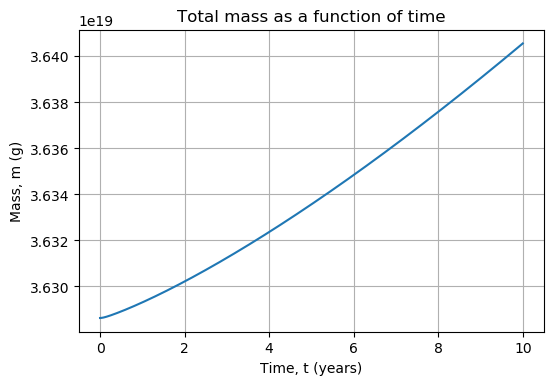

In [12]:
def calc_M(C_sim,z):
    M = []
    for c in C_sim:
        m = simps(c,z)*12
        m_total = m*360e12
        M.append(m_total)
    return M

M = calc_M(C_sim,z)
    
print(f"CO_2 absorbed: {(M[-1]-M[0])/10} per year")

plt.figure(dpi=100)
plt.title('Total mass as a function of time')
plt.xlabel('Time, t (years)')
plt.ylabel('Mass, m (g)')
plt.plot(t/T*10,M)
plt.grid()
plt.show()

**Problem 2 Task 4:**
After plotting the total mass of DIC in the time interval $2020$-$2030$, we find the average amount of $CO_2$ absorbed by the entire ocean in a year. Here we compare the mass in the water column at the beginning of the simulation and the mass at the end, and then take the average value of the increase over the $10$ years. The result of this gives us that the ocean absorbs approximately $1.2\cdot 10^{16}$g $CO_2$ per year. 

**Problem 2 Task 5:**
Researchers have estimated that the oceans absorb anthropogenic $CO_2$ at a rate of about $2.5\cdot10^{15}$g per year (Gruber's number). As we can see above, the number we approximated for the ocean's annual absorption was around $1.2\cdot 10^{16}$g $CO_2$ per year, which is almost 5 times bigger than Gruber's number. With all the simplifications and approximations we did, we believe this is a good result, being so close to the result found by Gruber. 

However, the results are not identic. The main reason for this is the method we used and the simplifications we made. Our model is based on an one-dimensional diffusion model for the ocean. This is, of course, a simplification of reality, and will probably have an effect on the result. 

To find our number we also assumed the rate of increase of the $CO_2$-level in the atmosphere to be constant the next $10$ years. This means that the number we found is the average annual value of $CO_2$ absorbed in the oceans from $2020$ to $2030$. In Gruber's experiment they found the average annual value from $1994$ to $2007$. In our approximation, that would have given us a lower value of the annual increase in $CO_2$-levels. Which would have given us a lower value.

Another point is that in reality, the diffusivity in the mixed layer will depend on local conditions, wind and time of year. Thus, the values of $K_1$ and $z_0$ in equation 3 are only approximations. The value of $K_0$ is also an approximation. However, these approximations will probably not effect the result in any major way.